In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029806.jpg
/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029690.jpg
/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029736.jpg
/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029790.jpg
/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029697.jpg
/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029822.jpg
/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029689.jpg
/kaggle/input/skin-diseases-detection-using-deep-learning-small/IMG_CLASSES_DATASET/5. Melanocytic Nevi/ISIC_0029739.jpg
/kaggle/input/skin-diseases-dete

In [46]:
%pip install --upgrade pip
%pip uninstall -y tensorflow
%pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
Using cached tensorflow-2.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (620.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorf

In [47]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 50

In [48]:
KAGGLE_DATASET_PATH = r"/kaggle/input/skin-diseases-detection-using-deep-learning-small"

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    KAGGLE_DATASET_PATH,  #Directory containing the dataset For colab (r"/content/IMG_CLASSES_DATASET",)
    shuffle=True,  #Shuffle the dataset
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #Resize images to 256x256 pixels
    batch_size=BATCH_SIZE  #Batch size for training
    )

# For Kaggle KAGGLE_DATASET_PATH = r"../input/your-private-dataset-slug/IMG_CLASSES_DATASET"

Found 6900 files belonging to 1 classes.


In [49]:
class_names = [name.split('(')[0].strip() for name in dataset.class_names]
class_names

['IMG_CLASSES_DATASET']

In [50]:
len(dataset)

108

In [51]:
108*64

6912

# 6912 images in total last batch was not proper
# 64 was Batch size

# EXPLORE DATA

In [52]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(64, 256, 256, 3)


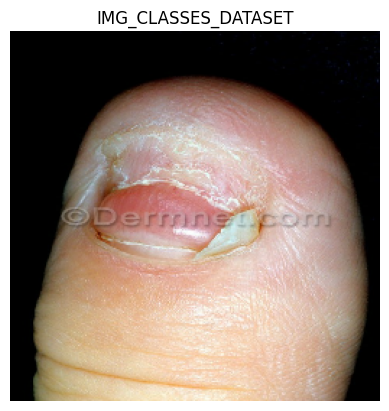

In [53]:
for image_batch, labels_batch in dataset.take(1):
    # print(image_batch[0]) # it will give image as a tensor
    # print(image_batch[0].numpy()) # it will give label as a numpy array
    print(image_batch.shape)  # (32, 256, 256, 3) 32 images of size 256x256 with 3 channels
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # Display the first image
    plt.axis("off")  # Hide the axis
    plt.title(class_names[labels_batch[0]])  # Display the label of the first

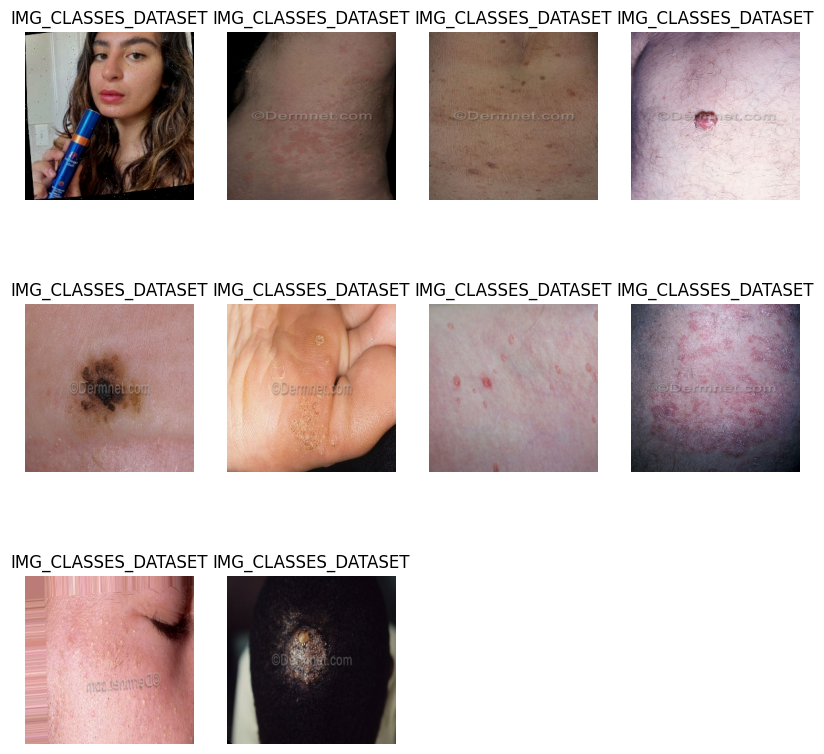

In [54]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


# **Reasoning**:
Iterate through the dataset to count the number of images in each class and store the counts in a dictionary.


In [55]:
from collections import Counter

class_counts = Counter()
for _, labels_batch in dataset:
    class_counts.update(labels_batch.numpy())

sorted_class_counts = sorted(class_counts.items(), key=lambda item: item[0])

for class_index, count in sorted_class_counts:
    print(f"Class {class_names[class_index]}: {count} images")

Class IMG_CLASSES_DATASET: 6900 images


In [56]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Get the true labels from the dataset
all_labels = []
for _, labels_batch in dataset:
    all_labels.extend(labels_batch.numpy())

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 1.0}


# Split the DATASET

In [57]:
train_size = 0.8
len(dataset)*train_size

86.4

In [58]:
train_ds=dataset.take(86)  # 86 batches for training
len(train_ds)

86

In [59]:
test_ds=dataset.skip(86)  # Skip the first 86 batches for validtion and test
len(test_ds)  # 22 batches for validation and test

22

In [60]:
val_size = 0.1
len(dataset)*val_size

10.8

In [61]:
val_ds=test_ds.take(11)  # 11 batches for validation
len(val_ds)

11

In [62]:
test_ds=test_ds.skip(6)  # 11 batches for validation
len(test_ds)

16

# Function to Split Dataset into Train, Test and Validation

In [63]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=1000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [64]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [65]:
len(train_ds), len(val_ds), len(test_ds)

(86, 10, 12)

# Caching

for second iteration we will use the same dataset, so we will cache it to speed up the process. Data is in main memory.

In [66]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Pre-Processing

# Scaling

In [67]:
# resize_and_rescale = tf.keras.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.experimental.preprocessing.Rescaling(1.0/255)

# ])

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

# DataAugmention
for making model Robust

with diffferent angles, brightness, contrast, etc.

In [68]:

# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2)
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

# Build the model
We are using CNN for train the data

In [69]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),
    tf.keras.layers.Rescaling(1.0/255),
    # data_augmentation,   # Data augmentation

    # Apply 2D convolution (layers, kernel size, activation)
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.2), # after CNN layer there is pooling layer max pooling or min #reduce size and preserve feature


    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)), layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes , activation='softmax')  # Output layer with softmax

])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [70]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,617 (717.25 KB)

 Trainable params: 183,617 (717.25 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))



In [72]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS ,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    class_weight=class_weights_dict # Use the calculated class weights
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:938: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/86 ━━━━━━━━━━━━━━━━━━━━ 46:39 33s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00

I0000 00:00:1759339768.375040     127 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 75s 500ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:

history.params

In [ ]:
history.history.keys()

In [ ]:
len(history.history['accuracy'])  # we can plot these history values in chart

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

we can plot these history values in chart

In [ ]:
plt.figure(figsize=(16, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# Make a Prediction

In [ ]:

import numpy as np

In [ ]:
np.argmax([2.189804e-04, 9.080725e-01, 9.170856e-02])  # output of the below prediction

In [ ]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')  # Display the first image in the batch
    first_label = labels_batch[0]  # Get the label of the first image

    print("First image to predict: ")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Batch prediction: ", batch_prediction[0])
    # print(class_names[np.argmax(batch_prediction[0])])  # Display the predicted label for the first image
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

In [ ]:
plt.figure (figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        # ax = plt.subplot(3, 4, i + 1)
        # plt.imshow(image_batch[i].numpy().astype("uint8"))
        # predicted_class, confidence = predict(model, image_batch)
        # plt.title(f"Predicted: {predicted_class} ({confidence}%)")
        # plt.axis("off")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Predicted: {predicted_class} ({confidence}%)\nActual: {actual_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Save The Models


In [ ]:

import os

In [ ]:
model_version=1
model.save(f"../saved_models/{model_version}.keras")

In [ ]:
model_version=2
model.save(f"../saved_models/{model_version}")

# Auto increment version number and models saved

In [ ]:
import os
# Get all folder/file names that are digits, convert to int, or use 0 if none
existing_versions = [int(i) for i in os.listdir("../saved_models/") if i.isdigit()]
model_version = max(existing_versions, default=0) + 1
model.save(f"../saved_models/{model_version}.keras")

In [ ]:
import os
# Get all folder/file names that are digits, convert to int, or use 0 if none
existing_versions = [int(i) for i in os.listdir("../saved_models/") if i.isdigit()]
model_version = max(existing_versions, default=0) + 1
model.save(f"../saved_models/{model_version}.keras")  # Add .keras extension for Keras format

In [ ]:
model_version = 2
model.export(f"../models/{model_version}")